# Functions

In [1]:
import torch
import numpy as np

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
eval_metrics = ['silog', 'abs_rel', 'log10', 'rms', 'sq_rel', 'log_rms', 'd1', 'd2', 'd3']

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()

    rms = (gt - pred) ** 2
    rms = np.sqrt(rms.mean())

    log_rms = (np.log(gt) - np.log(pred)) ** 2
    log_rms = np.sqrt(log_rms.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)

    return [silog, abs_rel, log10, rms, sq_rel, log_rms, d1, d2, d3]

# Evo dataset

## Focal dist

In [3]:
# Intrinsics matrices: (x_focal, y_focal, x_pp, y_pp)
K_maxtrces = {
    'ckad_01_ckad_2020-10-29-16-53-38_0': (
        1052.69873046875,
        1052.69873046875,
        969.119079589844,
        555.560913085938,
    ),
    'hospital_01_2020-07-14-14-03-23_0': (
        1412.705078125,
        1412.705078125,
        967.168579101562,
        543.377807617188,
    ),
    'ipcp_03_2020-06-23_ipcp_ipcp_n1-03_2020-06-23-16-54-40Z_converted.evo1a_old_default': (
        1411.85119628906,
        1411.85119628906,
        991.805480957031,
        505.537628173828,
    ),
    'ipcp_03_2020-08-19_ipcp_ipcp_n1-03_2020-08-18-10-14-48Z_converted.evo1a_old_default': (
        1418.53186035156,
        1418.53186035156,
        963.149108886719,
        525.431640625,
    ),
    'kalibr_002_2021-03-10_gnss_tests_kalibr-2_n1-002_2021-03-10-10-59-42Z_.evo1a_record_default': (
        521.493103027344,
        521.493103027344,
        630.518432617188,
        362.928863525391,
    ),
    'kalibr_002_kalibr-2_n1-002_2021-03-02-12-35-04Z_.evo1a_record_default': (
        521.493103027344,
        521.493103027344,
        630.518432617188,
        362.928863525391,
    ),
    'kalibr_002_kalibr-2_n1-002_2021-03-02-12-48-36Z_.evo1a_record_default': (
        521.493103027344,
        521.493103027344,
        630.518432617188,
        362.928863525391,
    ),
    'kalibr_03_2020-05-22_kalibr_2020-05-22-18-40-28_full_route_high_speed': (
        1410.72094726563,
        1410.72094726563,
        991.791381835938,
        505.526275634766,
    ),
    'kalibr_03_2020-06-01_kalibr_2020-06-01-16-38-16_0': (
        1411.34484863281,
        1411.34484863281,
        991.828979492188,
        505.558074951172,
    ),
    'kalibr_04_2020-12-03_2020-12-03-13-26-10_0_ZED': (
        523.876708984375,
        523.876708984375,
        647.893188476563,
        369.270965576172,
    ),
    'ckad_01_ckad_2020-10-29-17-01-56_0': (
        1052.69873046875,
        1052.69873046875,
        969.119079589844,
        555.560913085938,
    ),
    'hospital_01_2020-07-14-16-59-35_0': (
        1412.67077636719,
        1412.67077636719,
        967.1748046875,
        543.375671386719,
    ),
    'ipcp_03_2020-06-23_ipcp_2020-06-23-16-48-18_0': (
        1418.07263183594,
        1418.07263183594,
        991.793395996094,
        505.523162841797,
    ),
    'ipcp_03_2020-08-19_ipcp_2020-08-19-20-23-09_0': (
        1418.53186035156,
        1418.53186035156,
        963.149108886719,
        525.431640625,
    ),
    'kalibr_04_2021-01-18_snow_2021-01-18-15-29-39_0': (
        523.876708984375,
        523.876708984375,
        647.893188476563,
        369.270965576172,
    ),
    'kalibr_04_2021-01-18_snow_2021-01-18-15-37-39_0': (
        523.876708984375,
        523.876708984375,
        647.893188476563,
        369.270965576172,
    ),
    'kapotnya_02_2020-02-26_kapotnya_2020-02-26-15-27-06_0': (
        1409.71423339844,
        1409.71423339844,
        991.831970214844,
        505.561462402344,
    ),
    'kapotnya_02_2020-02-26_kapotnya_2020-02-26-15-09-42_0': (
        1418.07263183594,
        1418.07263183594,
        991.793395996094,
        505.523162841797,
    ),
    'kapotnya_02_2020-02-26_kapotnya_2020-02-26-15-34-18_0': (
        1409.71423339844,
        1409.71423339844,
        991.831970214844,
        505.561462402344,
    ),
    'kapotnya_02_2020-02-26_kapotnya_2020-02-26-15-42-08_0': (
        1409.71423339844,
        1409.71423339844,
        991.831970214844,
        505.561462402344,
    ),
}

## Split data

In [4]:
from pathlib import Path
import pandas as pd


evo_dir = Path("/home/dvkorshunov/mono_depth/monocular_depth_estimation/datasets/bags_historical")
data = pd.read_csv(evo_dir / "markup.csv")
data = data[data.depth_fname.notna()]

In [5]:
scenes = data.image.str.rsplit("_", n=2, expand=True)[0].str.split("/", n=1, expand=True)[1].unique()

bts_data = []
for row in data.itertuples():
    scene = row.image.rsplit("_", maxsplit=2)[0].split("/")[1]
    bts_data.append({
        "image": row.image,
        "depth": row.depth_fname,
        "focal": K_maxtrces[scene][0],
        "split": row.split,
    })
    
splited = pd.DataFrame(bts_data)

In [6]:
import csv

train_fname = evo_dir / "tmp_train.txt"
val_fname = evo_dir / "tmp_val.txt"
test_fname = evo_dir / "test_val.txt"
columns = ["image", "depth", "focal"]
splited[splited.split == "train"][columns].to_csv(
    train_fname,
    header=False,
    index=False,
    sep=" ",
    quoting=csv.QUOTE_NONE,
    escapechar=" ",
)
splited[splited.split == "val"][columns].to_csv(
    val_fname,
    header=False,
    index=False,
    sep=" ",
    quoting=csv.QUOTE_NONE,
    escapechar=" ",
)
splited[splited.split == "test"][columns].to_csv(
    test_fname,
    header=False,
    index=False,
    sep=" ",
    quoting=csv.QUOTE_NONE,
    escapechar=" ",
)

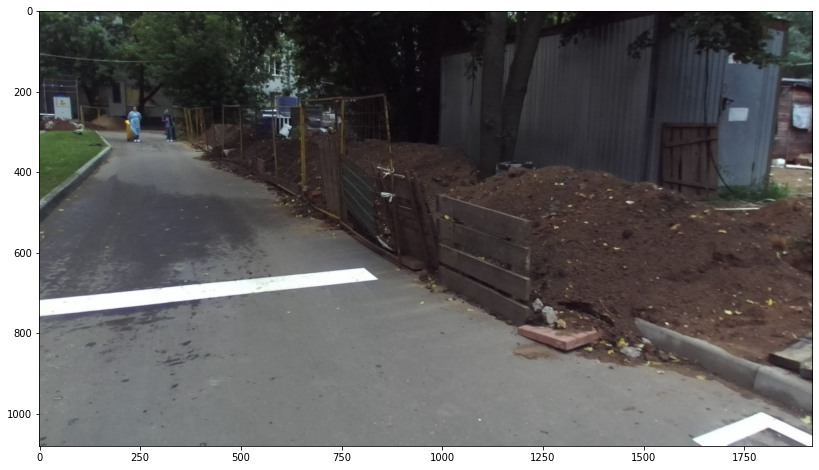

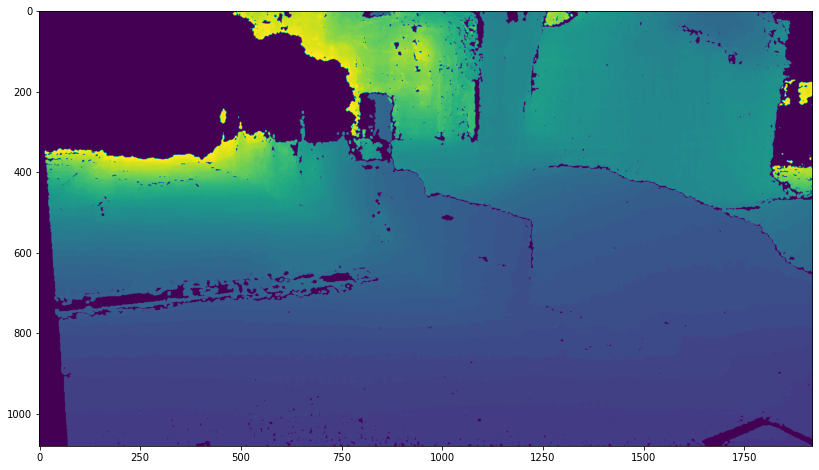

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

num = 500
img_fname = evo_dir / splited.image[num]
depth_fname = evo_dir / splited.depth[num]
image = Image.open(img_fname)
depth = Image.open(depth_fname)
plt.figure(figsize=(14, 8))
plt.imshow(image)
plt.show()
plt.figure(figsize=(14, 8))
plt.imshow(depth)
plt.show()

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

for row in splited.itertuples():
    img_fname = evo_dir / row.image
    depth_fname = evo_dir / row.depth
    depth = Image.open(depth_fname)
    depth_gt = np.asarray(depth, dtype=np.float32)
    print(depth_gt.max(), end=" ")
    if depth_gt.max() < 1:
        image = Image.open(img_fname)
        plt.figure(figsize=(14, 8))
        plt.imshow(image)
        plt.show()
        plt.figure(figsize=(14, 8))
        plt.imshow(depth)
        plt.show()

117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.

117.0 117.0 117.0 116.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 116.0 117.0 116.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 116.0 114.0 113.0 116.0 116.0 117.0 117.0 116.0 116.0 117.0 117.0 117.0 117.0 116.0 116.0 116.0 114.0 113.0 117.0 115.0 116.0 117.0 117.0 114.0 117.0 116.0 117.0 117.0 117.0 117.0 116.0 117.0 117.0 117.0 117.0 117.0 117.0 116.0 117.0 116.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 116.0 117.0 117.0 117.0 116.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 116.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 116.0 117.0 117.0 117.0 116.0 116.0 105.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.0 117.

# BTS

In [9]:
import sys
bts_dir = "/home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/bts"
bts_torch_dir = bts_dir + "/pytorch"
bts_pretrains_dir = bts_dir + "/models"
checkpoint_path = bts_pretrains_dir + "/bts_eigen_v2_pytorch_densenet121/model"
dataset_dir = "/home/dvkorshunov/mono_depth/monocular_depth_estimation/datasets/datasets/kitti/"
sys.path.insert(1, bts_torch_dir)

In [10]:
from collections import namedtuple

arguments = (
    "encoder "
    "data_path "
    "dataset "
    "filenames_file "
    "filenames_file_eval "
    "model_name "
    "checkpoint_path "
    "input_height "
    "input_width "
    "max_depth "
    "bts_size "
    "do_kb_crop "
    "distributed "
    "batch_size "
    "num_threads "
    "use_right "
    "gt_path "
    "do_random_rotate "
)
Params = namedtuple('Params', arguments)
params = Params(
    encoder="densenet121_bts",
    data_path=evo_dir,
    gt_path=evo_dir,
    dataset="kitti",
    filenames_file=train_fname.as_posix(),
    filenames_file_eval=val_fname.as_posix(),
    model_name="bts_eigen_v2_pytorch_densenet121",
    checkpoint_path=checkpoint_path,
    input_height=352,
    input_width=1216,
    max_depth=80,
    bts_size=512,
    do_kb_crop=True,
    distributed=False,
    batch_size=1,
    num_threads=1,
    use_right=False,
    do_random_rotate=False,
)

# Load pretrains

In [11]:
# ! mkdir -p {bts_pretrains_dir}
# ! wget -nc https://cogaplex-bts.s3.ap-northeast-2.amazonaws.com/bts_eigen_v2_pytorch_densenet121.zip -O {bts_pretrains_dir + "/bts_eigen_v2_pytorch_densenet121.zip"}
# ! unzip -o {bts_pretrains_dir + "/bts_eigen_v2_pytorch_densenet121.zip"} -d {bts_pretrains_dir}    

# Profile

In [12]:
from tqdm.notebook import tqdm
from torch.autograd import Variable
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

from bts_dataloader import BtsDataLoader
from bts import BtsModel

model = BtsModel(params=params)
model = torch.nn.DataParallel(model)

checkpoint = torch.load(params.checkpoint_path, map_location=torch.device(device.type))
model.load_state_dict(checkpoint["model"])
model.eval()
model.to(device.type)

DataParallel(
  (module): BtsModel(
    (encoder): encoder(
      (base_model): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer

In [13]:
from tqdm.notebook import tqdm

dataloader = BtsDataLoader(params, mode="train")
data = next(iter(dataloader.data))
image = data["image"]
depth = data["depth"]


pred_depths = []

with torch.no_grad():
    for num, sample in tqdm(enumerate(dataloader.data)):
        if num > 20:
            break
        image = Variable(sample["image"].cuda())
        focal = Variable(sample["focal"].cuda())
        
        lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)
        depth_est = depth_est.cpu().numpy().squeeze()
        pred_depths.append(depth_est)
        
        depth_gt = sample["depth"].numpy().squeeze()
        print(depth_gt.max(), end=" ")
#         print(compute_errors(depth_gt, depth_est))



0it [00:00, ?it/s]

13.0 0.0 0.0 0.0 13.0 17.0 13.0 12.0 0.0 13.0 13.0 14.0 14.0 14.0 0.0 0.0 0.0 0.0 14.0 0.0 0.0 

In [14]:
depth_gt.shape

(352, 1216)

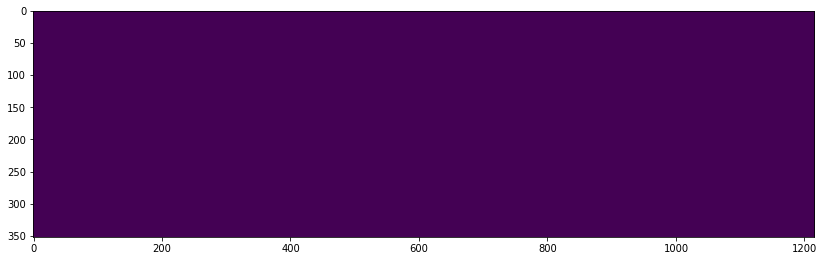

In [15]:
plt.figure(figsize=(14,8))
plt.imshow(depth_gt)
plt.show()

In [16]:
import os

def test(params):
    opts = params
    global gt_depths, is_missing, missing_ids
    gt_depths = []
    is_missing = []
    missing_ids = set()
    write_summary = False
    steps = set()

    if os.path.isdir(opts.checkpoint_path):
        import glob

        models = [f for f in glob.glob(opts.checkpoint_path + "/model*")]

        for model in models:
            # print(model)
            step = model.split('-')[-1]
            steps.add('{:06d}'.format(int(step)))

        lines = []
        if os.path.exists(opts.checkpoint_path + '/evaluated_checkpoints'):
            with open(opts.checkpoint_path + '/evaluated_checkpoints') as file:
                lines = file.readlines()

        for line in lines:
            if line.rstrip() in steps:
                steps.remove(line.rstrip())

        steps = sorted(steps)
        if opts.log_directory != '':
            summary_path = os.path.join(opts.log_directory, opts.model_name)
        else:
            summary_path = os.path.join(opts.checkpoint_path, 'eval')

        write_summary = True
    else:
        steps.add('{:06d}'.format(int(opts.checkpoint_path.split('-')[-1])))

    if len(steps) == 0:
        print('No new model to evaluate. Abort.')
        return

    opts.mode = 'test'
    dataloader = BtsDataLoader(opts, 'test')

    model = BtsModel(params=params)

    cudnn.benchmark = True

    if write_summary:
        summary_writer = SummaryWriter(summary_path, flush_secs=30)

    for step in steps:
        if os.path.isdir(opts.checkpoint_path):
            checkpoint = torch.load(
                os.path.join(opts.checkpoint_path, 'model-' + str(int(step)))
            )
            model.load_state_dict(checkpoint['model'])
        else:
            checkpoint = torch.load(opts.checkpoint_path)
            model.load_state_dict(checkpoint['model'])

        model.eval()
        model.cuda()

        num_test_samples = get_num_lines(opts.filenames_file)

        with open(opts.filenames_file) as f:
            lines = f.readlines()

        print('now testing {} files for step {}'.format(num_test_samples, step))

        pred_depths = []

        start_time = time.time()
        with torch.no_grad():
            for _, sample in enumerate(dataloader.data):
                image = Variable(sample['image'].cuda())
                focal = Variable(sample['focal'].cuda())
                # Predict
                lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)
                pred_depths.append(depth_est.cpu().numpy().squeeze())

        elapsed_time = time.time() - start_time
        print('Elapesed time: %s' % str(elapsed_time))
        print('Done.')

        if len(gt_depths) == 0:
            for t_id in range(num_test_samples):

                splitted = lines[t_id].split()

                gt_depth_path = os.path.join(
                    opts.data_path,
                    splitted[0],
                    'front_depth_left',
                    splitted[0] + '_' + splitted[1] + '.png',
                )
                depth = cv2.imread(gt_depth_path, -1)
                gt_depths.append(depth)

        print('Computing errors')
        silog, log10, abs_rel, sq_rel, rms, log_rms, d1, d2, d3 = eval(
            pred_depths, int(step)
        )

        if write_summary:
            summary_writer.add_scalar('silog', silog.mean(), int(step))
            summary_writer.add_scalar('abs_rel', abs_rel.mean(), int(step))
            summary_writer.add_scalar('log10', log10.mean(), int(step))
            summary_writer.add_scalar('sq_rel', sq_rel.mean(), int(step))
            summary_writer.add_scalar('rms', rms.mean(), int(step))
            summary_writer.add_scalar('log_rms', log_rms.mean(), int(step))
            summary_writer.add_scalar('d1', d1.mean(), int(step))
            summary_writer.add_scalar('d2', d2.mean(), int(step))
            summary_writer.add_scalar('d3', d3.mean(), int(step))
            summary_writer.flush()

            with open(
                os.path.dirname(opts.checkpoint_path) + '/evaluated_checkpoints', 'a'
            ) as file:
                file.write(step + '\n')

        print('Evaluation done')

In [17]:
test(params)

ValueError: invalid literal for int() with base 10: '/home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/bts/models/bts_eigen_v2_pytorch_densenet121/model'

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14,8))
# plt.imshow(image.squeeze().permute(1,2,0))
# plt.imshow(depth.squeeze(1).permute(1,2,0))
# plt.show()

In [ ]:
from tqdm.notebook import tqdm
from torch.autograd import Variable
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

from bts_dataloader import BtsDataLoader
from bts import BtsModel

def get_num_lines(file_path):
    f = open(file_path, 'r')
    lines = f.readlines()
    f.close()
    return len(lines)

dataloader = BtsDataLoader(params, mode="test")
    
model = BtsModel(params=params)
model = torch.nn.DataParallel(model)

checkpoint = torch.load(params.checkpoint_path, map_location=torch.device(device.type))
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device.type)

In [ ]:
 pred_depths = []
        
start_time = time.time()
with torch.no_grad():
    for _, sample in enumerate(dataloader.data):
        image = Variable(sample['image'].cuda())
        focal = Variable(sample['focal'].cuda())
        # image = Variable(sample['image'])
        # focal = Variable(sample['focal'])
        # Predict
        lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)
        pred_depths.append(depth_est.cpu().numpy().squeeze())

In [ ]:
import time

num_params = sum([np.prod(p.size()) for p in model.parameters()])
print("Total number of parameters: {}".format(num_params))

num_test_samples = get_num_lines(params.filenames_file)

with open(params.filenames_file) as f:
    lines = f.readlines()

print('now testing {} files with {}'.format(num_test_samples, params.checkpoint_path))

pred_depths = []
pred_8x8s = []
pred_4x4s = []
pred_2x2s = []
pred_1x1s = []

start_time = time.time()
profile_data = []
with torch.no_grad():
    for num, sample in enumerate(tqdm(dataloader.data)):
        image = Variable(sample['image'].to(device.type))
        focal = Variable(sample['focal'].to(device.type))
        
#         # warm up
#         if num == 30:
#             print(profile_net(model, image, focal))
#             break
        # Predict
        lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)
        pred_depths.append(depth_est.cpu().numpy().squeeze())
        pred_8x8s.append(lpg8x8[0].cpu().numpy().squeeze())
        pred_4x4s.append(lpg4x4[0].cpu().numpy().squeeze())
        pred_2x2s.append(lpg2x2[0].cpu().numpy().squeeze())
        pred_1x1s.append(reduc1x1[0].cpu().numpy().squeeze())

elapsed_time = time.time() - start_time
print('Elapesed time: %s' % str(elapsed_time))
print('Done.')

In [ ]:
# with profile(
#     activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
#     record_shapes=True
# ) as prof:
#     with record_function("model_inference"):
#         model(inputs)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
# model = models.resnet18()
# inputs = torch.randn(5, 3, 224, 224)

# with profile(activities=[ProfilerActivity.CPU],
#         profile_memory=True, record_shapes=True) as prof:
#     model(inputs)

# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

# Train

In [ ]:
dataloader = BtsDataLoader(params, "train")
dataloader_eval = BtsDataLoader(params, "online_eval")

In [ ]:
num_epochs = 1
epoch = 0
while epoch < num_epochs:
    for step, sample_batched in enumerate(dataloader.data):
        optimizer.zero_grad()
        before_op_time = time.time()

        image = torch.autograd.Variable(sample_batched['image'].cuda(args.gpu, non_blocking=True))
        focal = torch.autograd.Variable(sample_batched['focal'].cuda(args.gpu, non_blocking=True))
        depth_gt = torch.autograd.Variable(sample_batched['depth'].cuda(args.gpu, non_blocking=True))

        lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)

        if args.dataset == 'nyu':
            mask = depth_gt > 0.1
        else:
            mask = depth_gt > 1.0

        loss = silog_criterion.forward(depth_est, depth_gt, mask.to(torch.bool))
        loss.backward()
        for param_group in optimizer.param_groups:
            current_lr = (args.learning_rate - end_learning_rate) * (1 - global_step / num_total_steps) ** 0.9 + end_learning_rate
            param_group['lr'] = current_lr

        optimizer.step()

        if not args.multiprocessing_distributed or (args.multiprocessing_distributed and args.rank % ngpus_per_node == 0):
            print('[epoch][s/s_per_e/gs]: [{}][{}/{}/{}], lr: {:.12f}, loss: {:.12f}'.format(epoch, step, steps_per_epoch, global_step, current_lr, loss))
            if np.isnan(loss.cpu().item()):
                print('NaN in loss occurred. Aborting training.')
                return -1

        duration += time.time() - before_op_time
        if global_step and global_step % args.log_freq == 0 and not model_just_loaded:
            var_sum = [var.sum() for var in model.parameters() if var.requires_grad]
            var_cnt = len(var_sum)
            var_sum = np.sum(var_sum)
            examples_per_sec = args.batch_size / duration * args.log_freq
            duration = 0
            time_sofar = (time.time() - start_time) / 3600
            training_time_left = (num_total_steps / global_step - 1.0) * time_sofar
            if not args.multiprocessing_distributed or (args.multiprocessing_distributed and args.rank % ngpus_per_node == 0):
                print("{}".format(args.model_name))
            print_string = 'GPU: {} | examples/s: {:4.2f} | loss: {:.5f} | var sum: {:.3f} avg: {:.3f} | time elapsed: {:.2f}h | time left: {:.2f}h'
            print(print_string.format(args.gpu, examples_per_sec, loss, var_sum.item(), var_sum.item()/var_cnt, time_sofar, training_time_left))

            if not args.multiprocessing_distributed or (args.multiprocessing_distributed
                                                        and args.rank % ngpus_per_node == 0):
                writer.add_scalar('silog_loss', loss, global_step)
                writer.add_scalar('learning_rate', current_lr, global_step)
                writer.add_scalar('var average', var_sum.item()/var_cnt, global_step)
                depth_gt = torch.where(depth_gt < 1e-3, depth_gt * 0 + 1e3, depth_gt)
                for i in range(num_log_images):
                    writer.add_image('depth_gt/image/{}'.format(i), normalize_result(1/depth_gt[i, :, :, :].data), global_step)
                    writer.add_image('depth_est/image/{}'.format(i), normalize_result(1/depth_est[i, :, :, :].data), global_step)
                    writer.add_image('reduc1x1/image/{}'.format(i), normalize_result(1/reduc1x1[i, :, :, :].data), global_step)
                    writer.add_image('lpg2x2/image/{}'.format(i), normalize_result(1/lpg2x2[i, :, :, :].data), global_step)
                    writer.add_image('lpg4x4/image/{}'.format(i), normalize_result(1/lpg4x4[i, :, :, :].data), global_step)
                    writer.add_image('lpg8x8/image/{}'.format(i), normalize_result(1/lpg8x8[i, :, :, :].data), global_step)
                    writer.add_image('image/image/{}'.format(i), inv_normalize(image[i, :, :, :]).data, global_step)
                writer.flush()

        if not args.do_online_eval and global_step and global_step % args.save_freq == 0:
            if not args.multiprocessing_distributed or (args.multiprocessing_distributed and args.rank % ngpus_per_node == 0):
                checkpoint = {'global_step': global_step,
                              'model': model.state_dict(),
                              'optimizer': optimizer.state_dict()}
                torch.save(checkpoint, args.log_directory + '/' + args.model_name + '/model-{}'.format(global_step))

        if args.do_online_eval and global_step and global_step % args.eval_freq == 0 and not model_just_loaded:
            time.sleep(0.1)
            model.eval()
            eval_measures = online_eval(model, dataloader_eval, gpu, ngpus_per_node)
            if eval_measures is not None:
                for i in range(9):
                    eval_summary_writer.add_scalar(eval_metrics[i], eval_measures[i].cpu(), int(global_step))
                    measure = eval_measures[i]
                    is_best = False
                    if i < 6 and measure < best_eval_measures_lower_better[i]:
                        old_best = best_eval_measures_lower_better[i].item()
                        best_eval_measures_lower_better[i] = measure.item()
                        is_best = True
                    elif i >= 6 and measure > best_eval_measures_higher_better[i-6]:
                        old_best = best_eval_measures_higher_better[i-6].item()
                        best_eval_measures_higher_better[i-6] = measure.item()
                        is_best = True
                    if is_best:
                        old_best_step = best_eval_steps[i]
                        old_best_name = '/model-{}-best_{}_{:.5f}'.format(old_best_step, eval_metrics[i], old_best)
                        model_path = args.log_directory + '/' + args.model_name + old_best_name
                        if os.path.exists(model_path):
                            command = 'rm {}'.format(model_path)
                            os.system(command)
                        best_eval_steps[i] = global_step
                        model_save_name = '/model-{}-best_{}_{:.5f}'.format(global_step, eval_metrics[i], measure)
                        print('New best for {}. Saving model: {}'.format(eval_metrics[i], model_save_name))
                        checkpoint = {'global_step': global_step,
                                      'model': model.state_dict(),
                                      'optimizer': optimizer.state_dict(),
                                      'best_eval_measures_higher_better': best_eval_measures_higher_better,
                                      'best_eval_measures_lower_better': best_eval_measures_lower_better,
                                      'best_eval_steps': best_eval_steps
                                      }
                        torch.save(checkpoint, args.log_directory + '/' + args.model_name + model_save_name)
                eval_summary_writer.flush()
            model.train()
            block_print()
            set_misc(model)
            enable_print()

        model_just_loaded = False
        global_step += 1

    epoch += 1

In [ ]:
pred_depths = []
gt_depths = []
for num, sample in enumerate(tqdm(dataloader.data)):
    image = Variable(sample['image'].to(device.type))
    focal = Variable(sample['focal'].to(device.type))
    gt_depths.append(sample['depth'].cpu().numpy().squeeze())
    # Predict
    lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)
    pred_depths.append(depth_est.cpu().numpy().squeeze())
    pred_8x8s.append(lpg8x8[0].cpu().numpy().squeeze())
    pred_4x4s.append(lpg4x4[0].cpu().numpy().squeeze())
    pred_2x2s.append(lpg2x2[0].cpu().numpy().squeeze())
    pred_1x1s.append(reduc1x1[0].cpu().numpy().squeeze())

In [ ]:
import time

num_params = sum([np.prod(p.size()) for p in model.parameters()])
print("Total number of parameters: {}".format(num_params))

num_test_samples = get_num_lines(params.filenames_file)

with open(params.filenames_file) as f:
    lines = f.readlines()

print('now testing {} files with {}'.format(num_test_samples, params.checkpoint_path))

pred_depths = []
pred_8x8s = []
pred_4x4s = []
pred_2x2s = []
pred_1x1s = []

start_time = time.time()
profile_data = []
with torch.no_grad():
    for num, sample in enumerate(tqdm(dataloader.data)):
        image = Variable(sample['image'].to(device.type))
        focal = Variable(sample['focal'].to(device.type))
        
        # warm up
        if num == 30:
            print(profile_net(model, image, focal))
            break
        # Predict
        lpg8x8, lpg4x4, lpg2x2, reduc1x1, depth_est = model(image, focal)
        pred_depths.append(depth_est.cpu().numpy().squeeze())
        pred_8x8s.append(lpg8x8[0].cpu().numpy().squeeze())
        pred_4x4s.append(lpg4x4[0].cpu().numpy().squeeze())
        pred_2x2s.append(lpg2x2[0].cpu().numpy().squeeze())
        pred_1x1s.append(reduc1x1[0].cpu().numpy().squeeze())

elapsed_time = time.time() - start_time
print('Elapesed time: %s' % str(elapsed_time))
print('Done.')

In [ ]:
# import pandas as pd

# df = pd.DataFrame(profile_data)
# df["elapsed_time, ms"]